In [5]:
import os
import librosa
import numpy as np

# 오디오 설정
SAMPLE_RATE = 16000
FRAME_SIZE = 1024
HOP_LENGTH = 512

def extract_freq_amp_phase(frame, sr):
    stft = librosa.stft(frame, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    magnitude, phase = np.abs(stft), np.angle(stft)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=FRAME_SIZE)
    dominant_bin = np.argmax(magnitude[:, 0])
    freq = freqs[dominant_bin]
    amp = np.mean(magnitude[dominant_bin])
    phase_val = phase[dominant_bin][0]
    return np.array([freq, amp, phase_val])

def extract_features_from_file(file_path, sr=SAMPLE_RATE):
    y, _ = librosa.load(file_path, sr=sr)
    features = []
    for i in range(0, len(y) - FRAME_SIZE, HOP_LENGTH):
        frame = y[i:i+FRAME_SIZE]
        feat = extract_freq_amp_phase(frame, sr)
        features.append(feat)
    return np.array(features)

# 모든 .wav 파일에서 특성 추출
def extract_all_features(wav_dir="./wav"):
    all_features = []
    for filename in os.listdir(wav_dir):
        if filename.endswith(".wav"):
            file_path = os.path.join(wav_dir, filename)
            print(f"📂 Processing: {filename}")
            feats = extract_features_from_file(file_path)
            all_features.append(feats)
    return np.vstack(all_features)  # 모든 파일의 결과를 하나로 합침

# 사용 예
features = extract_all_features()
print("✅ 전체 특성 shape:", features.shape)  # (전체 프레임 수, 3)

📂 Processing: noise_1.wav
📂 Processing: noise_10.wav
📂 Processing: noise_100.wav
📂 Processing: noise_1000.wav
📂 Processing: noise_1001.wav
📂 Processing: noise_1002.wav
📂 Processing: noise_1003.wav
📂 Processing: noise_1004.wav
📂 Processing: noise_1005.wav
📂 Processing: noise_1006.wav
📂 Processing: noise_1007.wav
📂 Processing: noise_1008.wav
📂 Processing: noise_1009.wav
📂 Processing: noise_101.wav
📂 Processing: noise_1010.wav
📂 Processing: noise_1011.wav
📂 Processing: noise_1012.wav
📂 Processing: noise_1013.wav
📂 Processing: noise_1014.wav
📂 Processing: noise_1015.wav
📂 Processing: noise_1016.wav
📂 Processing: noise_1017.wav
📂 Processing: noise_1018.wav
📂 Processing: noise_1019.wav
📂 Processing: noise_102.wav
📂 Processing: noise_1020.wav
📂 Processing: noise_1021.wav
📂 Processing: noise_1022.wav
📂 Processing: noise_1023.wav
📂 Processing: noise_1024.wav
📂 Processing: noise_1025.wav
📂 Processing: noise_1026.wav
📂 Processing: noise_1027.wav
📂 Processing: noise_1028.wav
📂 Processing: noise_10

In [7]:
import numpy as np

def create_sequences(features, window_size=5):
    X, y = [], []
    for i in range(len(features) - window_size):
        seq_x = features[i:i+window_size]      # 입력: 5프레임 (window)
        seq_y = features[i+window_size]        # 출력: 다음 프레임
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
# 이전 단계에서 features = (전체 프레임 수, 3)
X, y = create_sequences(features, window_size=5)

print("X shape:", X.shape)  # (샘플 수, 5, 3)
print("y shape:", y.shape)  # (샘플 수, 3)

X shape: (1215195, 5, 3)
y shape: (1215195, 3)


In [9]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# X: (samples, 5, 3), y: (samples, 3) 형태라고 가정

def preprocess_and_scale(X, y):
    # 1. X reshape: (samples, 5, 3) -> (samples, 15)
    X_reshaped = X.reshape(X.shape[0], -1)

    # 2. MinMaxScaler 생성 및 적합
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # 3. X, y 스케일링
    X_scaled = scaler_x.fit_transform(X_reshaped)
    y_scaled = scaler_y.fit_transform(y)

    # 4. X 다시 reshape: (samples, 15) -> (samples, 5, 3)
    X_scaled = X_scaled.reshape(X.shape)

    # 5. 스케일러 저장
    joblib.dump(scaler_x, "scaler_x.joblib")
    joblib.dump(scaler_y, "scaler_y.joblib")

    print(f"✅ X 정규화 완료: {X_scaled.shape}")
    print(f"✅ y 정규화 완료: {y_scaled.shape}")

    return X_scaled, y_scaled, scaler_x, scaler_y

# 사용 예시
X_scaled, y_scaled, scaler_x, scaler_y = preprocess_and_scale(X, y)


✅ X 정규화 완료: (1215195, 5, 3)
✅ y 정규화 완료: (1215195, 3)


Epoch 1/10
34178/34178 [==============================] - 267s 8ms/step - loss: 0.0343 - mae: 0.1172 - val_loss: 0.0330 - val_mae: 0.1124
Epoch 2/10
34178/34178 [==============================] - 287s 8ms/step - loss: 0.0327 - mae: 0.1126 - val_loss: 0.0329 - val_mae: 0.1147
Epoch 3/10
34178/34178 [==============================] - 283s 8ms/step - loss: 0.0327 - mae: 0.1125 - val_loss: 0.0330 - val_mae: 0.1129
Epoch 4/10
34178/34178 [==============================] - 268s 8ms/step - loss: 0.0327 - mae: 0.1125 - val_loss: 0.0329 - val_mae: 0.1139
Epoch 5/10
34178/34178 [==============================] - 262s 8ms/step - loss: 0.0327 - mae: 0.1125 - val_loss: 0.0329 - val_mae: 0.1143
Epoch 6/10
34178/34178 [==============================] - 248s 7ms/step - loss: 0.0326 - mae: 0.1126 - val_loss: 0.0329 - val_mae: 0.1147
Epoch 7/10
34178/34178 [==============================] - 278s 8ms/step - loss: 0.0324 - mae: 0.1116 - val_loss: 0.0326 - val_mae: 0.1113
Epoch 8/10
34178/34178 [==========

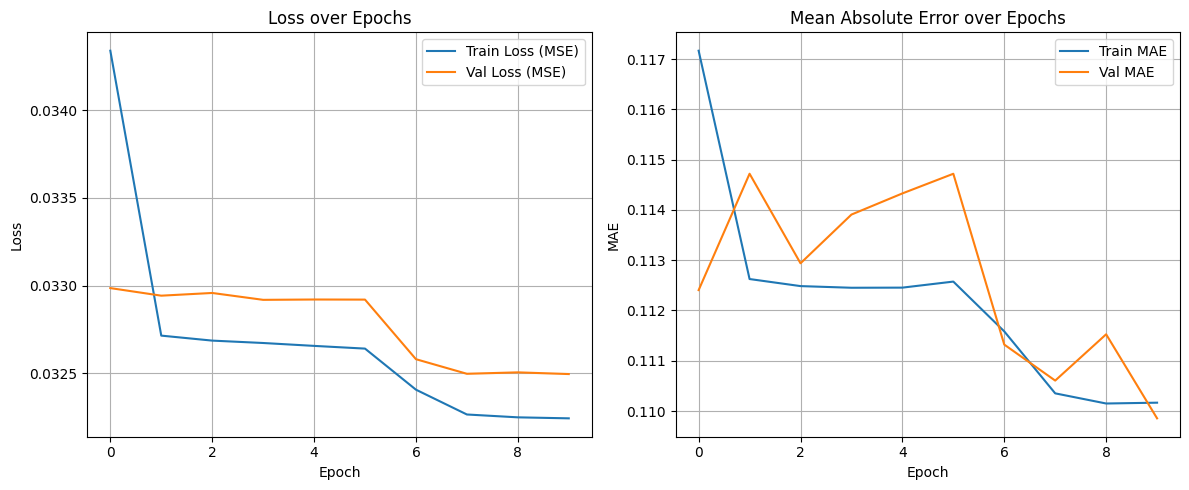

✅ 모델 저장 완료: transformer_estimator.h5


In [10]:
import tensorflow as tf # typing: ignore
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model # typing: ignore
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add # typing: ignore
from tensorflow.keras.callbacks import EarlyStopping # typing: ignore

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)  # (5, 3)

    # Multi-Head Attention 블록
    attn = MultiHeadAttention(num_heads=2, key_dim=16)(inputs, inputs)
    attn = Dropout(0.1)(attn)
    x = Add()([inputs, attn])
    x = LayerNormalization()(x)

    # Feed Forward 블록
    ff = Dense(64, activation='relu')(x)
    ff = Dropout(0.1)(ff)
    ff = Dense(3)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    # 평균 풀링으로 시퀀스 축소
    x = tf.reduce_mean(x, axis=1)  # (batch_size, 3)

    outputs = Dense(3)(x)  # [freq, amp, phase] 회귀 출력
    model = Model(inputs, outputs)
    return model

# 모델 생성
model = build_transformer_model(input_shape=(5, 3))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# EarlyStopping 콜백 정의
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 학습
history = model.fit(
    X_scaled, y_scaled,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # MAE 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Mean Absolute Error over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 모델 저장
model.save("transformer_estimator.h5")
print("✅ 모델 저장 완료: transformer_estimator.h5")

🔊 실시간 노이즈 캔슬링 (입력 + 반대파) 출력 중... (Ctrl+C 종료)

📊 기록된 데이터를 시각화합니다...


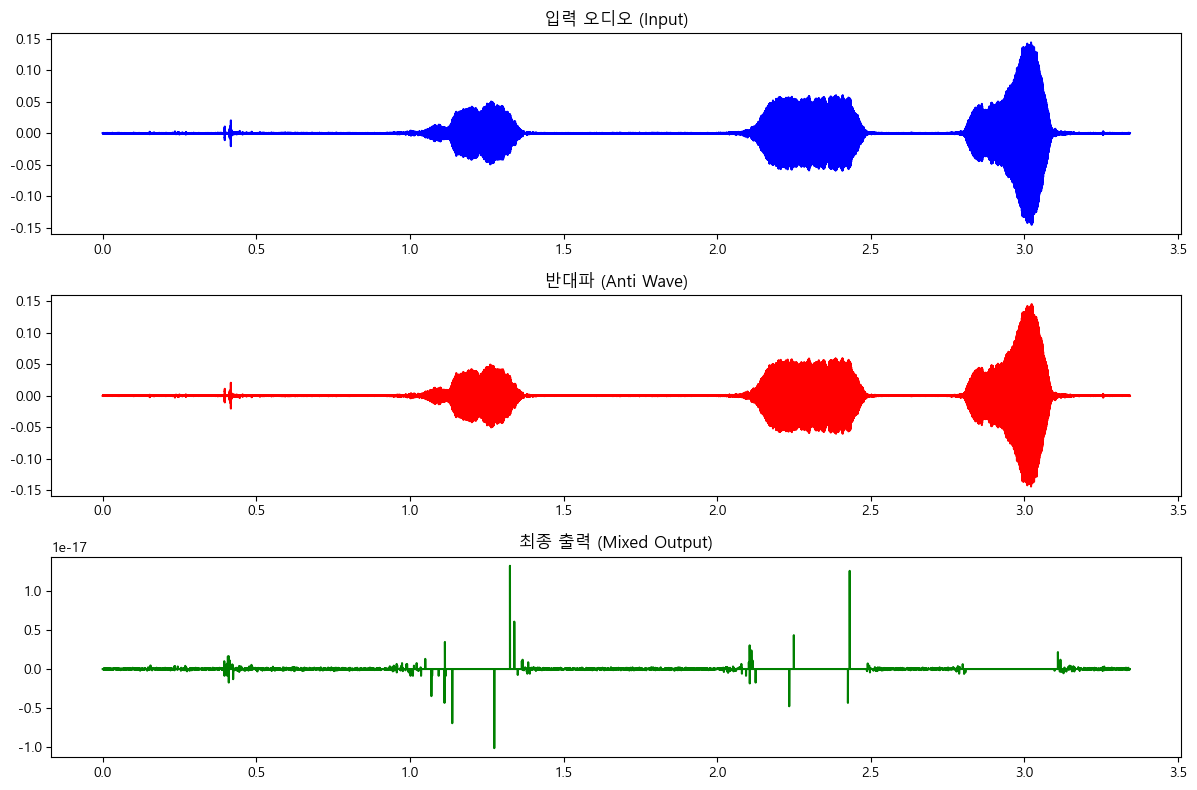

SystemExit: 0

In [29]:
import numpy as np
import sounddevice as sd
import time
import matplotlib.pyplot as plt
import signal
import sys
import matplotlib

# 한글 폰트 설정
matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

SAMPLE_RATE = 44100  # 샘플레이트 통일
FRAME_SIZE = 512     # 프레임 크기 줄여서 지연 최소화

input_audio_log = []
anti_wave_log = []
mixed_audio_log = []

def generate_anti_wave_from_frame(frame):
    fft = np.fft.rfft(frame)
    magnitude = np.abs(fft)
    phase = np.angle(fft)
    anti_fft = magnitude * np.exp(1j * (phase + np.pi))
    anti_wave = np.fft.irfft(anti_fft)
    anti_wave = anti_wave[:len(frame)]
    anti_wave = np.clip(anti_wave, -1, 1)
    return anti_wave.astype(np.float32)

def audio_callback(indata, outdata, frames, time_info, status):
    global input_audio_log, anti_wave_log, mixed_audio_log

    if status:
        print("Status:", status)

    mono = indata[:, 0]
    anti_wave = generate_anti_wave_from_frame(mono)

    amplify_scale = 1.0
    amplified_anti_wave = np.clip(anti_wave * amplify_scale, -1, 1)

    mixed = np.clip(mono + amplified_anti_wave, -1, 1)

    # mono 출력 (입력 + 반대파 합친 신호)
    outdata[:] = mixed.reshape(-1, 1)

    input_audio_log.append(mono.copy())
    anti_wave_log.append(anti_wave.copy())
    mixed_audio_log.append(mixed.copy())

def handle_exit(sig, frame):
    print("\n📊 기록된 데이터를 시각화합니다...")
    input_audio = np.concatenate(input_audio_log)
    anti_wave = np.concatenate(anti_wave_log)
    mixed_audio = np.concatenate(mixed_audio_log)
    t = np.linspace(0, len(input_audio) / SAMPLE_RATE, len(input_audio))

    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(t, input_audio, label="Original Input", color="blue")
    plt.title("입력 오디오 (Input)")

    plt.subplot(3, 1, 2)
    plt.plot(t, anti_wave, label="Anti Wave", color="red")
    plt.title("반대파 (Anti Wave)")

    plt.subplot(3, 1, 3)
    plt.plot(t, mixed_audio, label="Mixed Output", color="green")
    plt.title("최종 출력 (Mixed Output)")

    plt.tight_layout()
    plt.show()
    sys.exit(0)

signal.signal(signal.SIGINT, handle_exit)

input_device = None
output_device = None

print("🔊 실시간 노이즈 캔슬링 (입력 + 반대파) 출력 중... (Ctrl+C 종료)")
with sd.Stream(device=(input_device, output_device),
               channels=1,         # 모노 출력 (1채널)
               samplerate=SAMPLE_RATE,
               blocksize=FRAME_SIZE,
               callback=audio_callback):
    while True:
        time.sleep(0.1)

🔊 실시간 노이즈 캔슬링 중... (Ctrl+C로 종료)
🎯 예측: freq=993.1 Hz, amp=0.531, phase=0.05 rad


⚠️ input overflow, output underflow



📊 실시간 반응 종료, 시각화 중...


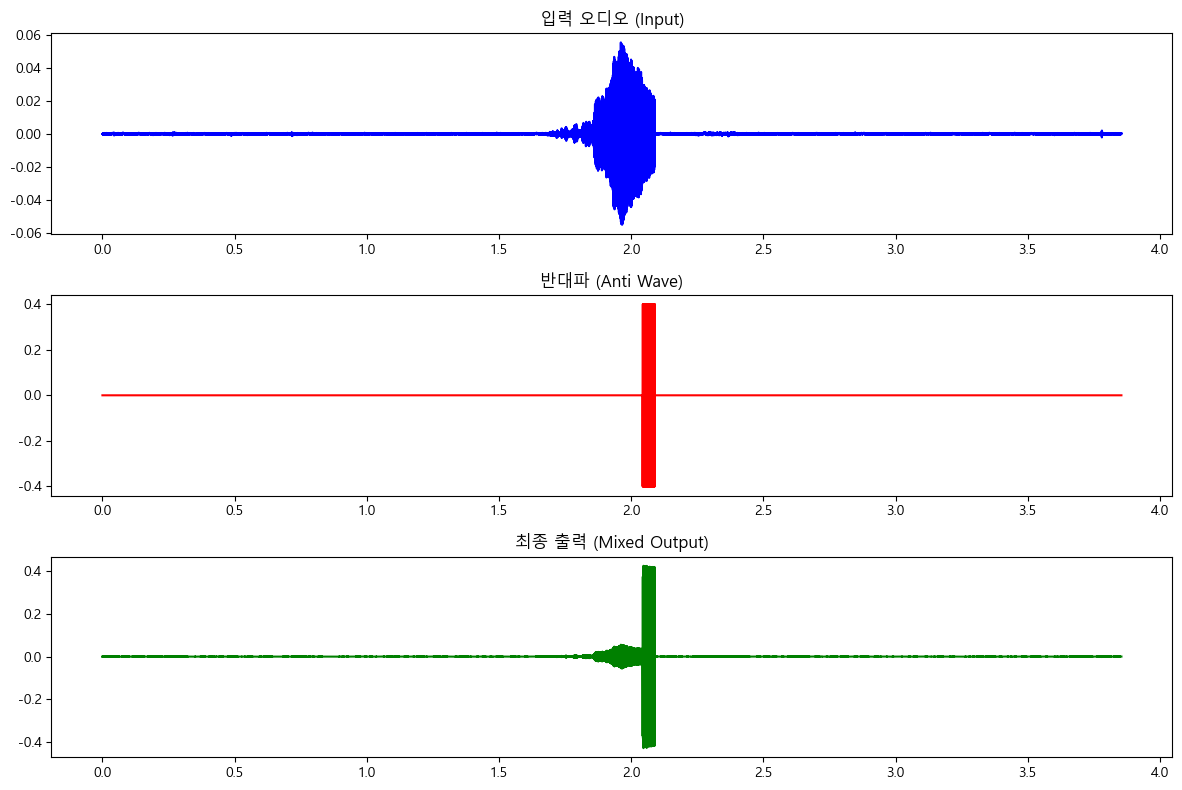

SystemExit: 0

C:\Users\owner\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [16]:
import numpy as np
import sounddevice as sd
from scipy.fft import fft, fftfreq
from scipy.signal import hilbert
from tensorflow.keras.models import load_model
import joblib
from collections import deque
import signal
import sys
import matplotlib.pyplot as plt
import time
import matplotlib

# 한글 폰트 설정
matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 모델 및 스케일러 불러오기
model = load_model('transformer_estimator.h5')
scaler_x = joblib.load('scaler_x.joblib')
scaler_y = joblib.load('scaler_y.joblib')

# 오디오 설정
SAMPLE_RATE = 44100
BLOCKSIZE = 2048
input_device = 1   # 마이크 번호
output_device = 4  # 스피커 번호

# 버퍼 및 로그
history_buffer = deque(maxlen=5)
pred_history = deque(maxlen=5)
input_audio_log = []
anti_wave_log = []
mixed_audio_log = []

# 특성 추출
def extract_features(frame, samplerate):
    mono = frame.flatten()
    if np.max(np.abs(mono)) < 0.01:
        return [0, 0, 0]

    fft_vals = np.abs(fft(mono))
    fft_freqs = fftfreq(len(mono), 1 / samplerate)
    idx = np.argmax(fft_vals[:len(fft_vals) // 2])
    peak_freq = abs(fft_freqs[idx])
    peak_amp = np.max(np.abs(mono))

    analytic_signal = hilbert(mono)
    phase = np.unwrap(np.angle(analytic_signal))[0] % (2 * np.pi)

    return [peak_freq, peak_amp, phase]

# 위상 평균 계산
def vector_phase_mean(phases):
    vec = np.exp(1j * np.array(phases))
    mean_angle = np.angle(np.mean(vec))
    return mean_angle + 2 * np.pi if mean_angle < 0 else mean_angle

# 반대파 생성
def generate_anti_wave(freq, amp, phase, samplerate, length):
    if freq == 0 or amp == 0:
        return np.zeros(length)
    amp = np.clip(amp, 0.0, 0.4)
    t = np.arange(length) / samplerate
    return amp * np.sin(2 * np.pi * freq * t + phase + np.pi)

# 콜백 함수
def callback(indata, outdata, frames, time_info, status):
    if status:
        print(f"⚠️ {status}", file=sys.stderr)

    mono = indata[:, 0]
    input_audio_log.append(mono.copy())

    if np.max(np.abs(mono)) < 0.01:
        silence = np.zeros(frames)
        anti_wave_log.append(silence)
        mixed_audio_log.append(mono.copy())
        outdata[:] = np.stack([mono, mono], axis=1)
        return

    features = extract_features(mono, SAMPLE_RATE)
    history_buffer.append(features)

    if len(history_buffer) < 5:
        silence = np.zeros(frames)
        anti_wave_log.append(silence)
        mixed_audio_log.append(mono.copy())
        outdata[:] = np.stack([mono, mono], axis=1)
        return

    input_seq = np.array(history_buffer)
    input_scaled = scaler_x.transform(input_seq.flatten().reshape(1, -1)).reshape(1, 5, 3)

    pred_scaled = model.predict(input_scaled, verbose=0)
    pred = scaler_y.inverse_transform(pred_scaled)[0]
    freq, amp, phase = pred

    if not (20 <= freq <= 20000): freq = 0
    if not (0 <= amp <= 1): amp = 0
    if not (0 <= phase <= 2 * np.pi): phase = 0

    pred_history.append([freq, amp, phase])
    freq = np.mean([p[0] for p in pred_history])
    amp = np.mean([p[1] for p in pred_history])
    phase = vector_phase_mean([p[2] for p in pred_history])

    print(f"🎯 예측: freq={freq:.1f} Hz, amp={amp:.3f}, phase={phase:.2f} rad")

    anti_wave = generate_anti_wave(freq, amp, phase, SAMPLE_RATE, frames)
    anti_wave_log.append(anti_wave.copy())

    mixed = np.clip(mono + anti_wave, -1, 1)
    mixed_audio_log.append(mixed.copy())
    outdata[:] = np.stack([mixed, mixed], axis=1)

# 종료 처리
def handle_exit(sig, frame):
    print("\n📊 실시간 반응 종료, 시각화 중...")
    input_audio = np.concatenate(input_audio_log)
    anti_wave = np.concatenate(anti_wave_log)
    mixed_audio = np.concatenate(mixed_audio_log)
    t = np.linspace(0, len(input_audio) / SAMPLE_RATE, len(input_audio))

    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(t, input_audio, color='blue')
    plt.title('입력 오디오 (Input)')

    plt.subplot(3, 1, 2)
    plt.plot(t, anti_wave, color='red')
    plt.title('반대파 (Anti Wave)')

    plt.subplot(3, 1, 3)
    plt.plot(t, mixed_audio, color='green')
    plt.title('최종 출력 (Mixed Output)')

    plt.tight_layout()
    plt.show()
    sys.exit(0)

signal.signal(signal.SIGINT, handle_exit)

# 스트리밍 시작
print("🔊 실시간 노이즈 캔슬링 중... (Ctrl+C로 종료)")

with sd.Stream(device=(input_device, output_device),
               channels=(1, 2),
               samplerate=SAMPLE_RATE,
               blocksize=BLOCKSIZE,
               callback=callback):
    while True:
        time.sleep(0.1)
